# Matplotlib绘图

时间-浓度序列图、箱型图、密度散点图的绘制

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.use('AGG')
from netCDF4 import Dataset
from sklearn import metrics
from scipy.stats import linregress
from matplotlib.colors import LogNorm
# 在jupyter中显示图片
%matplotlib inline

## 1. 数据
20160107-0205 CMAQ模型模拟值及ResNet模型预测值 日均值 ppm 
模拟范围：中国及周边区域  
网格：140 × 210  
高度：近地面层  
上海 (70, 107)   

In [2]:
y_pred = np.load('res_10.npy') * 1000
y_true = np.load('cmaq_10.npy') * 1000
print(y_pred.shape)
species = ['NO2', 'NO', 'O3', 'H2O2', 'ROOH', 'ETHENE', 'ETHANE', '·OH', 'HO2·','RO2·']

(30, 140, 210, 10)


In [3]:
# 物种名称下标
def sub_super(s):
    t = ''
    if s == 'O3P':
        t = 'O$\mathregular{(^3}$P)'
    elif s == 'O1D':
        t = 'O$\mathregular{(^1}$D)'
    else:
        if 'OLE' in s or 'AFG' in s or 'ALK' in s or s[0] == 'V' or s[0] == 'A' or s == 'BUTADIENE13' or s == 'TMBENZ124' or s == 'PAN2' or s == 'PRD' or s == 'xPROD2':
            return s
        else:
            s = list(s)
            for i in range(len(s)-1):
                if s[i+1].isdigit():
                    s[i+1] = '$\mathregular{_%d}$'%int(s[i+1])
                else:
                    continue
            t = ''.join(s)          
    return t


# 计算R2、NMB、RMSE
def get_r2(y_true, y):
    if (y_true == y).all():
        r2_score = 1
    else:
        slope, intercept, r_value, p_value, std_err = linregress(y_true, y) # 斜率、截距、相关系数R、p、标准差
        r2_score = r_value ** 2
    return r2_score
 
 
def get_nmb(y_true, y):
    a = np.sum(y - y_true)
    b = np.sum(y_true)
    if b.all() == 0:
        nmb = 0 
    else:
        nmb = a / b * 100    
    return nmb


def get_rmse(y_true, y):
    mse =  metrics.mean_squared_error(y_true, y)
    rmse = np.sqrt(mse)
    return rmse

## 2. 时间-浓度序列图  
以上海(70, 107)臭氧30d的数据为例

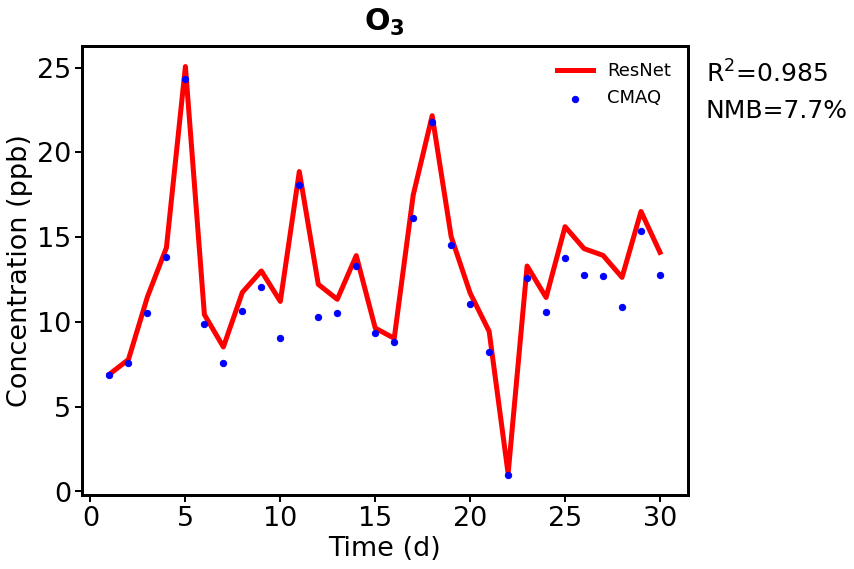

In [4]:
o3_pred = y_pred[:, 70, 107, 2]
o3_true = y_true[:, 70, 107, 2]
fig = plt.figure(figsize=(12, 8), frameon=False) # frameon=True可使用facecolor等参数
ax = fig.subplots()
t = np.arange(1,31)
ax.plot(t, o3_pred, 'r-', linewidth=5, zorder=0) # zorder确定绘图的顺序
ax.scatter(t, o3_true, c='b', s=40, zorder=1)
ax.tick_params(axis='both', width=2, length=7, labelsize=27) # 坐标刻度设置
#ax.set_ylim(min, max) # 限制坐标轴范围
ax.yaxis.get_major_formatter().set_powerlimits((-2, 2)) # 科学计数法
ax.locator_params(axis='y', nbins=6) # nbins将坐标轴分为n等份
# weights=['light','normal','medium','semibold','bold','heavy','black']
ax.set_title(sub_super("O3"), loc='center', y=1.02, fontweight='semibold', fontsize=30) 
# 边框粗细 
ax.spines['bottom'].set_linewidth(3)
ax.spines['left'].set_linewidth(3)
ax.spines['top'].set_linewidth(3)
ax.spines['right'].set_linewidth(3)
ax.set_xlabel('Time (d)', fontsize=27, fontweight='medium')  
ax.set_ylabel('Concentration (ppb)', fontsize=27, fontweight='medium') 
ax.legend(['ResNet','CMAQ'], bbox_to_anchor=(1,1), ncol=1, fontsize=18, frameon=False)
# 设置科学计数法的字体大小
tx2 = ax.yaxis.get_offset_text() 
tx2.set_fontsize(25)
# 计算R2、NMB
r2 = get_r2(o3_true, o3_pred)  
nmb = get_nmb(o3_true, o3_pred)
ax.text(1.03, 0.92, 
        '$\mathregular{R^2}$=%.3f' % r2, 
        fontsize=25, 
        fontweight='medium',
        transform=ax.transAxes,
        bbox=dict(boxstyle='square', fc='white', ec='white'),
        #bbox=dict(boxstyle='square', fc='none', ec='none'),
       )
ax.text(1.03, 0.84, 
        'NMB=%.1f%%' % nmb, 
        fontsize=25, 
        fontweight='medium',
        transform=ax.transAxes,
        bbox=dict(boxstyle='square', fc='white', ec='white'),
        #bbox=dict(boxstyle='square', fc='none', ec='none'),
        )
fig.tight_layout()
plt.savefig('o3_t-c.png')
plt.show()
plt.close()

## 3. 箱型图
观察数据分布

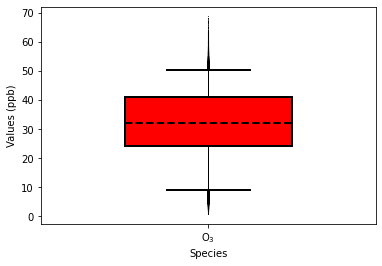

In [5]:
def plot_box(x):
    fig = plt.figure(figsize=(6, 4), frameon=False)
    ax = fig.subplots()
    capprops = dict(color='black', linewidth=2)
    boxprops = dict(color='black', linewidth=2) 
    flierprops = dict(marker='*', color='blue', markersize=0.2, linestyle='none')
    medianprops = dict(color='black', linewidth=2, linestyle='--')
    b = ax.boxplot(x, 
                   whis=[1, 99], # whis设置上下分位数
                   widths=0.5, 
                   labels=['$\mathregular{O_3}$'], 
                   #meanline=True,
                   #showmeans=True,
                   patch_artist=True,
                   capprops=capprops,
                   boxprops=boxprops,
                   flierprops=flierprops,
                   medianprops=medianprops,
                  )
    b['boxes'][0].set(facecolor='red')
    #ax.set_title('$\mathregular{O_3}$')
    ax.yaxis.get_major_formatter().set_powerlimits((-2, 2))
    ax.set_xlabel('Species')
    ax.set_ylabel('Values (ppb)')
    plt.savefig('o3_box.png')
    plt.show()
    plt.close()
    return


x = y_pred[:, :, :, 2].reshape(-1, 1)
plot_box(x)

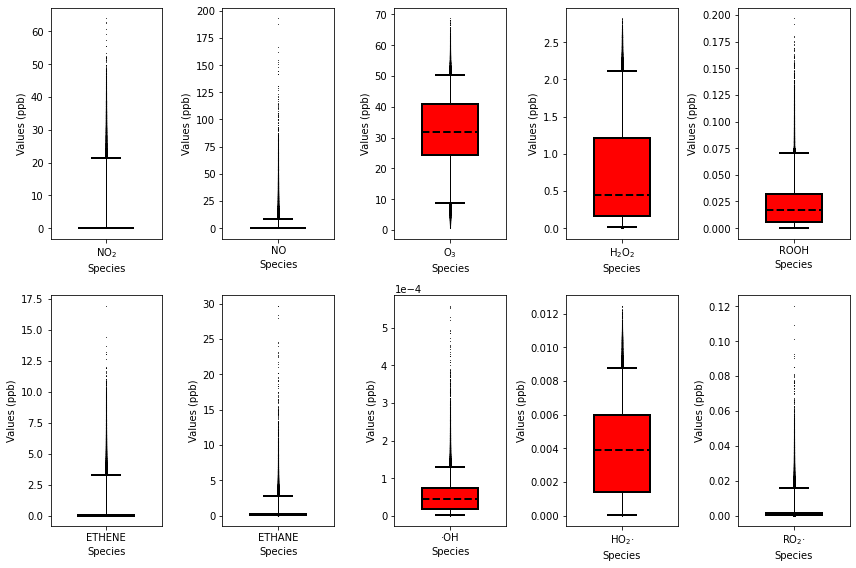

In [10]:
# 绘制多图
def plot_box_n(x, i):
    ax = fig.add_subplot(2, 5, i+1)
    capprops = dict(color='black', linewidth=2)
    boxprops = dict(color='black', linewidth=2) 
    flierprops = dict(marker='*', color='blue', markersize=0.2, linestyle='none')
    medianprops = dict(color='black', linewidth=2, linestyle='--')
    b = ax.boxplot(x, 
                   whis=[1, 99], # whis设置上下分位数
                   widths=0.5, 
                   labels=[sub_super(species[i])], 
                   #meanline=True,
                   #showmeans=True,
                   #showfliers=False,
                   patch_artist=True,
                   capprops=capprops,
                   boxprops=boxprops,
                   flierprops=flierprops,
                   medianprops=medianprops,
                  )
    b['boxes'][0].set(facecolor='red')
    #ax.set_title('$\mathregular{O_3}$')
    ax.yaxis.get_major_formatter().set_powerlimits((-3, 3))
    ax.set_xlabel('Species')
    ax.set_ylabel('Values (ppb)')
    return


fig = plt.figure(figsize=(12, 8), frameon=False)   
for i in range(10):
    x = y_pred[:, :, :, i].reshape(-1, 1)
    plot_box_n(x, i)
    
fig.tight_layout()    
plt.savefig('ten_species_box.png')
plt.show()
plt.close()

## 4. 密度散点图

R2 by scipy: 0.9839, R2 by sklearn: 0.9759


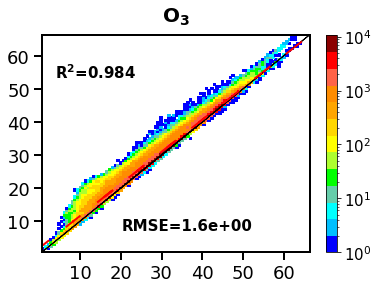

In [37]:
def plot_dense(x, y):
    '''
    x：真实值，array
    y：预测值，array
    '''
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    y_f_1 = slope * x + intercept   
    r2_score = r_value ** 2
    rmse = get_rmse(x, y) 
    color_list = ('blue', 'deepskyblue', 'cyan',
                  'mediumaquamarine', 'lime', 'greenyellow', 
                  'yellow', 'gold', 'orange', 'darkorange',
                  'tomato', 'red', 'DarkRed'
                  )
    cmap = mpl.colors.ListedColormap(color_list, name='plotmap') 
    fig = plt.figure(figsize=(6, 4))
    ax = fig.subplots()
    dense = ax.hist2d(x, y, bins=100, cmap=cmap, norm=LogNorm(), zorder=0)  # 双直方图，bins值越大显示越精细
    ax.plot(x, x, 'black', linewidth=1, zorder=1) # 1:1 直线
    ax.plot(x, y_f_1, 'r--', linewidth=2, dashes=(5, 15), zorder=2) # 最佳拟合直线
    ax.set_xlim(np.min(x), np.max(x))
    ax.set_ylim(np.min(x), np.max(x))   
    ax.xaxis.get_major_formatter().set_powerlimits((-2, 2)) 
    ax.yaxis.get_major_formatter().set_powerlimits((-2, 2)) 
    ax.locator_params(nbins=7)   
    ax.tick_params(axis='both', which='major', length=8, width=2, labelsize=18)    
    ax.set_title(sub_super('O3'), loc='center', fontsize=20, fontweight='semibold', y=1.03)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.spines['top'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)
    cb = fig.colorbar(dense[3], ax=ax)
    cb.ax.tick_params(labelsize=15)
    ax.text(0.05, 0.80, 
            '$\mathregular{R^2}$=%.3f' % r2_score, 
             fontsize=15,
             fontweight='semibold',              
             transform=ax.transAxes,
             bbox=dict(boxstyle='square', fc='white', ec='white')
             )
    ax.text(0.30, 0.10, 
             'RMSE=%.1e'% rmse,
             fontsize=15, 
             fontweight='semibold',
             transform=ax.transAxes,
             bbox=dict(boxstyle='square', fc='white', ec='white')
             )               
    return

o3_pred = y_pred[:, :, :, 2].reshape(-1)
o3_true = y_true[:, :, :, 2].reshape(-1)
plot_dense(o3_true, o3_pred)
# 两种R2的计算方法结果有差别
test_r2_1 = get_r2(o3_true, o3_pred)
test_r2_2 = metrics.r2_score(o3_true, o3_pred)
print("R2 by scipy: %.4f, R2 by sklearn: %.4f"%(test_r2_1, test_r2_2))